# 第3章 变换的层次和应用

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import cv2
import os

本节将从最一般的射影变换（单应变换）开始，介绍不同层次的变换。从一般到特殊，变换的层次依次为射影变换（Projective transform），仿射变换（Affine transform），相似变换（Similarity transform）， 欧式变换（Euclidean transform）。

由前面我们已经知道，最一般的射影变换$H$是一个$3×3$的矩阵。通过特殊化矩阵$H$的形式，可以得到不同层次的变换。原书中的下表总结了各种变换矩阵的形式。其中，$A=[a_{ij}]$是2×2的可逆矩阵，$R=[r_{ij}]$是2D旋转矩阵，$t=(t_x, t_y)^T$是2D平移矢量。仿射变换（6自由度）介于相似变换（4自由度）和射影变换（8自由度）之间。（**注意，这里列表中是点的变换，即$x'=Hx$,要实现线方程$l$的变换，因为$l^Tx=0$，变换后点仍在线上，有$l'^T Hx=0$，有$l'^TH=l^T$，所以有$l'=H^{-T}l$**.）
<img src="./pic/figure/3_1.jpg", width=520, heigth=540>
<font color=#A9A9A9 size=2><center>变换的层次 </center></font>

书中提供的实例能帮助直观理解不同的变换。图a是欧式或者相似变换，也就是日常所说的『旋转』『缩放』操作。图b是仿射变换，园被映射为了椭圆，地砖的直角也不再是90度。图c是射影变换，出现了平时摄影作品中的『近大远小』，平行线汇聚（***无穷远点被映射成了有限点***！这点很重要）。
<img src="./pic/figure/3_2.png", width=520, heigth=540>
<font color=#A9A9A9 size=2><center>变换层次的实例 </center></font>


### 不变量
***不变量***是在某种变换之下保持不变的元素。上面的表格『不变性质』列举了各种变换下的不变量。其中一些不变量是容易理解的，比如旋转变化下（欧式）物体的面积，角度都不会发生变化。其中的，**交比**，**无穷远性质**和**虚圆点**比较难理解。
不变量在多视几何中有重要的应用，下面分别介绍一些不变量。

### 交比
交比是在射影变换下的不变量。参考下图，交比的定义为：$Cross(A,B,C,D)=\frac{AC}{AD}:\frac{BC}{BD}$.交比不变即是指的在射影变换下
$$\frac{AC}{AD}:\frac{BC}{BD} = \frac{A'C'}{A'D'}:\frac{B'C'}{B'D'}$$
<img src="./pic/figure/3_3.png", width=220, heigth=240>
<font color=#A9A9A9 size=2><center>Robotics: Perception from Coursera </center></font>
利用交比，可以通过图像中已知长度的元素，实现其他位置的测距。下面考察一个利用交比不变性确定无穷远线的例子。如下图所示有
$$\frac{A'C'}{A'D'}:\frac{B'C'}{B'D'}=\frac{AC}{AD}:\frac{BC}{BD}$$
因为$D$点为无穷远点，所以有
$$\frac{A'C'}{A'D'}:\frac{B'C'}{B'D'}=\frac{AC}{BC} = 2$$
带入$A',B',C'$的像素坐标，即可得到求的$D'$的像素坐标；同样的方法能够求的另外一个方向的无穷远点，连接两个无穷远点即得到无穷远线。不借助任何平行线，也没有利用相机的内外参，仅仅利用图像中的一些几何信息，我们就得到了图像中的无穷远线。
<img src="./pic/figure/3_4.png", width=520, heigth=540>
<font color=#A9A9A9 size=2><center>利用交比找无穷远线 </center></font>

### 无穷远线
无穷远线（或者点）是在仿射变换下的不变量。从上面的地砖的例子可以直观感受到，仿射变换带来的是一种『压扁』的效果，平行线仍然保持平行，不会有交点。从数学上也能简单地说明这一点。无穷远点$(x_1,x_2,0)^T$乘以一个仿射矩阵$\left[ \begin{array} {cc}
A, t\\
{\bf0}, 1\\
\end{array} \right]$,因为仿射矩阵最后一行为$(0,0,1)$,所以点坐标最后一维仍为0，是一个无穷远点。相应的，无穷远点所在的无穷远线也保持不变。
由此可知，一旦辨认出了射影变换下的无穷远线${\bf{l_\infty}}=(0,0,1)^T$的位置，将其变换回无穷远处，即可恢复到仿射结构，即图像和最初的原图只相差一个仿射变换。

**例：对图像进行射影矫正（只差一个仿射变换）**

下面用具体的例子说明如何进行射影矫正使得图像和原图只差一个仿射变换。假设已经求得射影变换下的无穷远线的像为$l=(l_1,l_2,l_3)$，那么一个能把$(0,0,1)$映射到该像的变换是
$$\left[ \begin{array} {c}
l_1\\
l_2\\
l_3\\
\end{array} \right]=\left[ \begin{array} {ccc}
1& 0& l_1\\
0& 1& l_2\\
0& 0& l_3\\
\end{array} \right]\left[ \begin{array} {c}
0\\
0\\
1\\
\end{array} \right]$$
该变换矩阵$H$实现了无穷远线从仿射变换到射影变换，相应的$H^{-1}$实现从射影变换恢复到仿射结构（即平行线恢复平行而不是相交）。要实现图像的矫正，要应用点的变换，变换矩阵为$(H^{-1})^{-T}$，即$H^T$.需要说明的是，这里的变换$H$并不是唯一的，任何一个$H_AH^T$都能恢复到仿射变换（$H_A$是仍任意仿射变换）。用例子中的图片从直观上理解，只要将标语恢复为任何形式的『平行四边形』均可实现射影矫正。

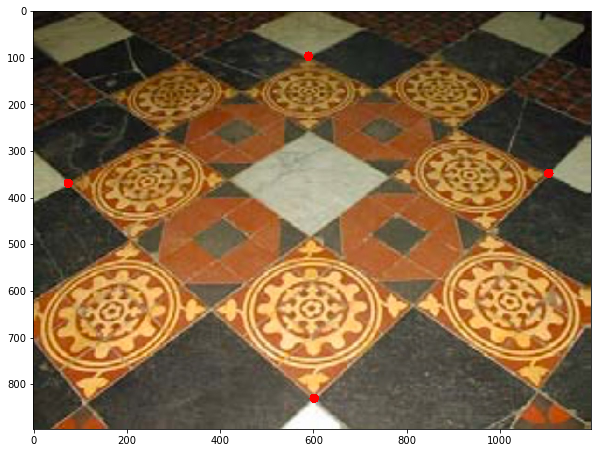

In [31]:
img = cv2.imread("./pic/3_1.jpg")
A = np.array([602, 830, 1])
B = np.array([1105, 349, 1])
C = np.array([590, 98, 1])
D = np.array([75, 370, 1])
points = [A,B,C,D]
for p in points:
    cv2.circle(img, (int(p[0]), int(p[1])), 10, (0,0,255), -1)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])

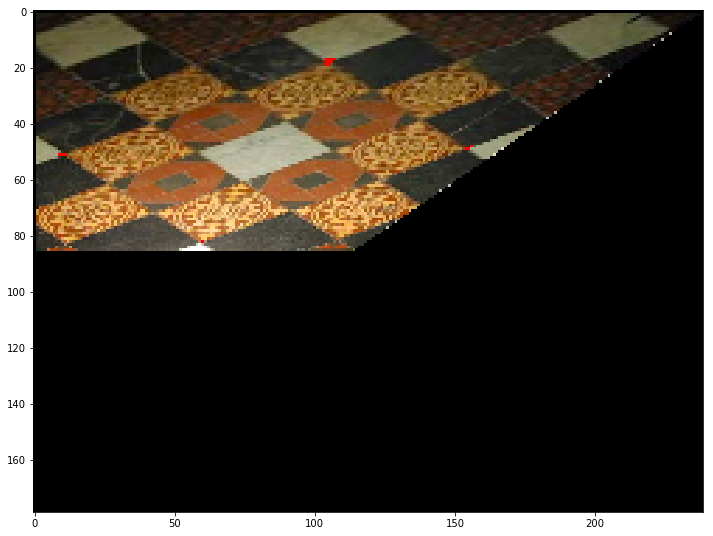

In [33]:
# 求两个组平行线诱导的无穷远点
l11 = np.cross(A, B)
l12 = np.cross(C, D)
vanish_point1 = np.cross(l11, l12)
vanish_point1 = vanish_point1 / vanish_point1[2] 
l21 = np.cross(A, D)
l22 = np.cross(C, B)
vanish_point2 = np.cross(l21, l22)
vanish_point2 = vanish_point2 / vanish_point2[2]
#求无穷远线
vanish_line = np.cross(vanish_point1, vanish_point2)
vanish_line = vanish_line / vanish_line[2]

#一个能使图像中的无穷远线映射回（0，0，1）T的变换是
H = np.array([[1, 0, 0],
              [0, 1, 0],
              [vanish_line[0], vanish_line[1], vanish_line[2]]])
#缩放图片加速
scale = 5
rectify_img = np.zeros([int(img.shape[0] / scale), int(img.shape[1] / scale),3],np.uint8)
w = img.shape[1]
h = img.shape[0]
for i in range(0, rectify_img.shape[0], 1):
        for j in range(0, rectify_img.shape[1], 1): 
            p = np.array([j * scale, i * scale, 1])
            p_rectify = np.linalg.inv(H).dot(p)
            p_rectify = p_rectify / p_rectify[2]
            if int(p_rectify[1]) > 0 and \
             int(p_rectify[1]) < h and \
             int(p_rectify[0]) > 0 and \
             int(p_rectify[0]) < w:
                rectify_img[i][j] = img[int(p_rectify[1])][int(p_rectify[0])]
plt.figure(figsize=(12,12))
plt.imshow(rectify_img[:,:,::-1])

### 虚圆点(circular points)
虚圆点是在相似变换下的不变量，坐标为$(1,i,0)^T$和$(1,-i,0)^T$.

通过具体的说明来理解虚圆点。圆是一种常见的二次曲线，两个圆相交于两个交点。在相似变换下，圆仍然是一个圆（也许半径会发生变化），所以两个圆仍然相交于两个交点。当仿射变换作用于图像时，圆变为椭圆，两个椭圆会产生四个交点。说明两个圆本身应该有4个交点，多出来的两个交点正是『虚圆点』，而这两个虚圆点在相似变换的空间只是不那么"显式可见"。由圆的方程
$$(x-aw)^2 + (y-bw)^2 = r^2w^2$$
可知，任意两个圆除了能通过联立方程求出两个实数域的交点之外，还有两个点$(1,i,0)^T$和$(1,-i,0)^T$是所有圆都会经过的点，也就是两个圆的另外两个交点。它们最后一维度的坐标是0，也是在无穷远处的点。

我们用前面矫正射影变换的仿射不变量来类比一下。仿射变换（相似变换）下平行线（两个圆）的"不可见"交点无穷远点（虚圆点），通过射影变换（仿射变换）使得平行线相交（圆变成椭圆），无穷远点（虚圆点）能够在图像上被辩识。

与虚圆点对应的二次曲线叫做**对偶二次曲线**，方程为
$${\bf{C^*_\infty}}=\left[ \begin{array} {ccc}
1,0,0\\
0,1,0\\
0,0,0\\
\end{array} \right]$$
能够证明，对偶二次曲线相似变换下保持不变。下面介绍一个恢复到欧式变换的例子。

**例：恢复图像度量性质（只差一个相似变换）**

在欧式空间下，直线$l=(l_1,l_2,l_3)^T$和$m=(m_1,m_2,m_3)^T$的夹角为
$$cos{\theta} = \frac{l_1m_1+l_2m_2}{\sqrt{(l_1^2 +l_2^2)(m_1^2+m_2^2)}}$$
通过引入对偶二次曲线，在射影空间下的夹角可以写作
$$cos{\theta} = \frac{\bf{l^TC^*_\infty m}}{\sqrt{(\bf{l^TC^*_\infty l})(\bf m^TC^*_\infty m)}}$$
容易证明，上式在射影变换下是不变的。（带入在点的变换$x^{'}=Hx$下, 线变换$l^{'}=H^{-T}l$，二次曲线变换$C^{*'}=HC^*H^T$即可）。也就是说，如果直线$l$和$m$正交，则有
$$\bf{l^TC^*_\infty m}=0$$
经过射影变换后，仍然有
$$\bf{l^{'T} C^*_\infty m^{'}}=0$$
利用这个性质，我们就能在图象上辨认出对偶二次曲线的像，将其变换回对偶二次曲线方程的变换，就能使得图像恢复度量性质。
对于平面上的每一组互相垂直的直线，都能提供一组约束。使用和第一章同样的方法，就能求的像的二次曲线方程。

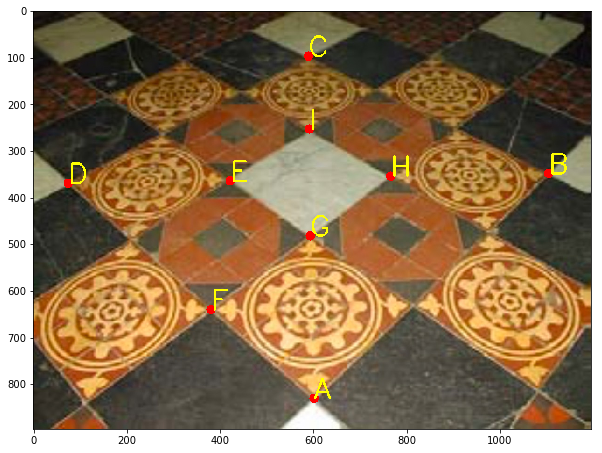

In [167]:
img = cv2.imread("./pic/3_1.jpg")
A = np.array([602, 830, 1])
B = np.array([1105, 349, 1])
C = np.array([590, 98, 1])
D = np.array([75, 370, 1])
E = np.array([422, 365, 1])
F = np.array([381, 640, 1])
G = np.array([594, 482, 1])
H = np.array([766, 355, 1])
I = np.array([592, 254, 1])
points = [A,B,C,D,E,F,G,H,I]
text = ["A","B","C","D","E","F","G","H","I"]
for index,p in enumerate(points):
    cv2.circle(img, (int(p[0]), int(p[1])), 10, (0,0,255), -1)
    cv2.putText(img, text[index],(int(p[0]), int(p[1])), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,255,255), 3)
plt.figure(figsize=(10,10))
plt.imshow(img[:,:,::-1])

In [168]:
from numpy.linalg import svd
l1 = np.cross(A, D)
l2 = np.cross(C, D)
l3 = np.cross(C, B)
l4 = np.cross(A, B)
l5 = np.cross(E, D)
l6 = np.cross(E, F)
l7 = np.cross(E, G)
l8 = np.cross(G, H)
l9 = np.cross(H, I)
l10 = np.cross(E, I)

#一共5组垂直直线，(l1,l2),(l3,l4),(l5,l6),(l7,l8),(l9,l10)
lines =[(l1,l2),(l3,l4),(l5,l6),(l7,l8),(l9,l10)]
A_ = []
for l in lines:
    constrain = [l[0][0]*l[1][0], \
                 (l[0][0]*l[1][1] + l[0][1]*l[1][0])/2, \
                 l[0][1]*l[1][1], \
                 (l[0][0]*l[1][2] + l[0][2]*l[1][0])/2, \
                 (l[0][1]*l[1][2] + l[0][2]*l[1][1])/2, \
                 l[0][2]*l[1][2]]
    A_.append(constrain)
A_ = np.array(A_)
u, s, vT = np.linalg.svd(A_)
v = vT.T
c = v[:,-1]
#二次曲线在射影图像上的像
C_matrix = np.array([[c[0],  c[1]/2, c[3]/2],
                     [c[1]/2,c[2],   c[4]/2],
                     [c[3]/2,c[4]/2, c[5]]])
U, S, VT = np.linalg.svd(C_matrix)

100%|██████████| 896/896 [00:07<00:00, 119.09it/s]


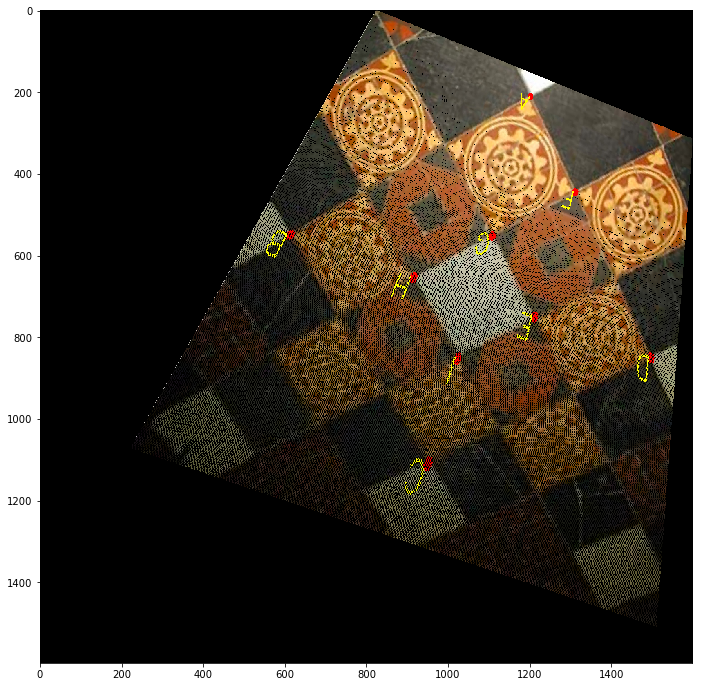

In [170]:
#让S变为[1,1,0]的形式
from tqdm import tqdm
scale = np.array([[np.sqrt(1.0/S[0]), 0, 0],
                 [0, np.sqrt(1.0/S[1]), 0],
                 [0, 0, 1]])
H_ = np.array(U).dot(scale)
w = img.shape[1]
h = img.shape[0]
points = []
origin = []
print("计算点的变换...")
for i in tqdm(range(0, img.shape[0], 1)):
        for j in range(0, img.shape[1], 1): 
            p = np.array([j, i, 1])
            p_rectify = H_.T.dot(p)#注意二次曲线的变换要转换为点的变换
            p_rectify = p_rectify / p_rectify[2]
            points.append([p_rectify[0], p_rectify[1]])
            origin.append([i,j])
points = np.array(points)
min_x = np.min(points)
max_x = np.max(points)
rectify_img = np.zeros([int(max_x - min_x + 1), int(max_x - min_x + 1), 3], np.uint8)
for i, p in enumerate(points):
    rectify_img[int(p[1]-min_x)][int(p[0]-min_x)] = img[origin[i][0]][origin[i][1]]
plt.figure(figsize=(12,12))
plt.imshow(rectify_img[:,:,::-1])